# <Center> NATURAL LANGUAGE PROCESSING </center>
## <center> Lab 10 - Relationship extraction and co-reference </center> 
### <Center> K Nidhi Sharma, 2148041 </center> 

## Relationship Extraction

Relationship extraction is the process of identification of relationships between different entities in a text.

In [ ]:
#Install & Import Dependencies
!python -m spacy download en_core_web_sm

In [ ]:
!pip install pandas
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.cli import download
download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Choose desired web content, scrape it and save it into CSV format

In [23]:
# indicate address for chosen URL
url = "https://www.rigzone.com/news/what_could_omicron_cost_global_oil_market-03-dec-2021-167199-article"
# open the URL for reading
html = urllib.request.urlopen(url)
# parsing the html file
htmlParse = BeautifulSoup(html, 'html.parser')

parsed_text = ""

for para in htmlParse.find_all("p"):
    parsed_text = " ".join((parsed_text, str(para.get_text())))    
    
sentences = [[i] for i in nlp(parsed_text).sents]

In [24]:
#Save the data into CSV
myheaders = ['sentence']
myvalues = sentences
filename = 'article_text.csv'
with open(filename, 'w',newline='') as myfile:
    writer = csv.writer(myfile)
    writer.writerow(myheaders)
    writer.writerows(myvalues)

In [26]:
#Import CSV file
csv_sentences = pd.read_csv("article_text.csv")

In [36]:
csv_sentences

,sentence
0,\n var ssdl =
1,"ssdl || {} \n ssdl.editorialMetaData = { 'Country' : 'All', \n'Region' : 'All', \n'company' : '', \n'sector' : 'Industry_Headlines', \n'industry_sector' : 'Downstream,Upstream', \n'audience' : 'N..."
2,"That’s according to Rystad Energy, which warned that, if the variant spreads rapidly, oil demand could fall by 1.3 million barrels per day, to 97.8 million barrels per day, in December 2021 and by..."
3,"The company noted, however, that as countries and governments learn to live with the Omicron variant, or vaccine manufacturers adapt existing shots to counter the variant, the full-year impact wil..."
4,"Average 2022 demand would fall to 98 million barrels per day, according to Rystad, which highlighted that this was a drop of 2.1 million barrels per day against its current base case scenario."
5,"“The likelihood of increasing lockdowns in the coming months has risen dramatically due to the new Omicron variant, and this will undoubtedly impact global oil demand,” Claudio Galimberti, Rystad’..."
6,"“Given the early stage of the variant outbreak and the unknowns related to contagiousness and vaccine efficacy, we can only hope this scenario turns out to be a false alarm."
7,"Still, if the risk is real, the oil market will need to recalibrate accordingly,” he added in the statement."
8,"Omicron Product Impact In the first quarter of 2022, demand for gasoline could fall by up to 1.3 million barrels per day to 24.2 million barrels per day due to Omicron, according to Rystad."
9,That’s a five percent decrease from its base levels of 25.5 million barrels per day.


#### Get Entity Pairs

In [27]:
#Funtion to read any sentence and return two entities
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [30]:
get_entities("Madhuri has 5 phones") #return entities

['Madhuri', '5  phones']

In [37]:
entity_pairs=[]
for i in tqdm(csv_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 33/33 [00:00<00:00, 78.58it/s]


#### Get Relations for the Entities

In [38]:
#Funtion to get the relation for each entity pair
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [40]:
get_relation("Krishna completed the task") #return relation

'completed'

In [41]:
relations=[get_relation(i) for i in tqdm(csv_sentences["sentence"])]

100%|██████████| 33/33 [00:00<00:00, 115.34it/s]


In [43]:
pd.Series(relations).value_counts()[:50]

said in            2
added in           2
announced          2
is                 2
ssdl               1
said               1
think              1
contact            1
reported to        1
include            1
risen for          1
administered as    1
been               1
added              1
impacted           1
displayed          1
admitted           1
cost               1
highlighted        1
see                1
show               1
warned             1
’s                 1
fall by            1
hope               1
fall to            1
noted              1
according to       1
love               1
dtype: int64

#### Display Entity Relations into Graphs

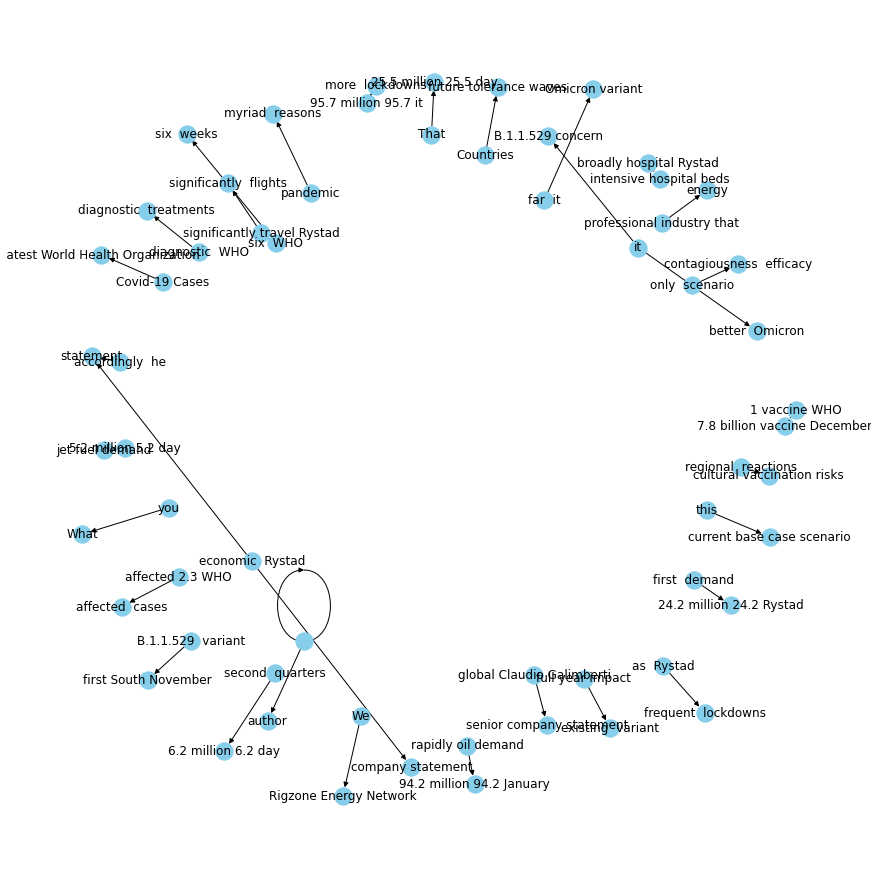

In [42]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

##### To filter the relations and obtain less crowded graph

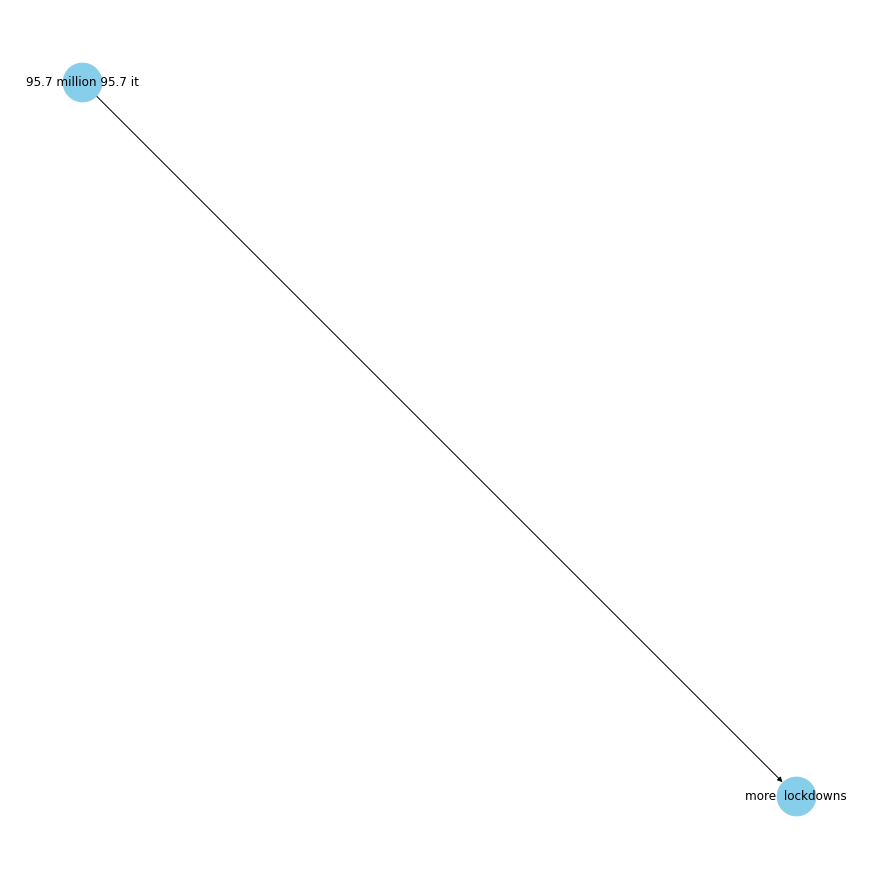

In [44]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cost"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()